In [1]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statistics 
from sklearn.model_selection import cross_validate
#from pysal.contrib.spint.gravity import Gravity
import networkx as nx
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import json
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from itertools import combinations, permutations
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Random Forest Feature Importance Viz

# Import data

In [2]:
svidf_by_county=pd.read_csv('SVI2018_US_COUNTY.csv')
svidf_by_county['FIPS']=svidf_by_county['FIPS'].astype(str)
svidf_by_county.set_index(['FIPS'],inplace=True)
svidf_by_county

,ST,STATE,ST_ABBR,COUNTY,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,...,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP
FIPS,,,,,,,,,,,,,,,,,,,,,
35039,35,NEW MEXICO,NM,Rio Arriba,"Rio Arriba County, New Mexico",5860.869195,39307,0,20044,71,...,0,0,0,1,-999,4160,588,10.6,1.5,32290
1001,1,ALABAMA,AL,Autauga,"Autauga County, Alabama",594.443459,55200,0,23315,71,...,0,0,0,0,0,3875,508,7.1,0.9,37301
1009,1,ALABAMA,AL,Blount,"Blount County, Alabama",644.830460,57645,0,24222,55,...,0,0,0,0,0,6303,732,11.0,1.3,40036
1013,1,ALABAMA,AL,Butler,"Butler County, Alabama",776.838201,20025,0,10026,51,...,0,0,0,0,0,2005,340,10.2,1.7,17280
1015,1,ALABAMA,AL,Calhoun,"Calhoun County, Alabama",605.867251,115098,0,53682,184,...,0,0,0,0,0,10686,796,9.4,0.7,117894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48131,48,TEXAS,TX,Duval,"Duval County, Texas",1793.476183,11355,0,5592,49,...,1,1,0,2,10,2656,406,24.5,3.7,9592
48505,48,TEXAS,TX,Zapata,"Zapata County, Texas",998.411980,14369,0,6388,26,...,1,0,0,2,10,4206,484,29.3,3.4,10924
48507,48,TEXAS,TX,Zavala,"Zavala County, Texas",1297.406535,12131,0,4344,20,...,1,1,0,2,10,2194,354,18.4,3.0,10672


In [3]:
import pickle
with open('featuresByCounty_0901.pickle','rb') as f:
    featuresByCounties_2=pickle.load(f)

In [4]:
week_adjust_2=list(featuresByCounties_2.keys())
week_adjust_2.remove('2020-03-03')
week_adjust_2.remove('2020-03-10')
week_adjust_2.remove('2020-03-17')
week_adjust_2

['2020-03-24',
 '2020-03-31',
 '2020-04-07',
 '2020-04-14',
 '2020-04-21',
 '2020-04-28',
 '2020-05-05',
 '2020-05-12',
 '2020-05-19',
 '2020-05-26',
 '2020-06-02',
 '2020-06-09',
 '2020-06-16',
 '2020-06-23']

In [5]:
tot_pop=svidf_by_county['E_TOTPOP'].to_dict()

for week in week_adjust_2:
    cases_per_100k={}
    featuresByCounties_2[week].index=featuresByCounties_2[week].index.astype(int)
    featuresByCounties_2[week].index=featuresByCounties_2[week].index.astype(str)
    for i,row in featuresByCounties_2[week].iterrows():
        #ii=('0' if len(i)<5 else '')+i
        if tot_pop[i]==0: print(i,week,row['CDC_new'])
        cases_per_100k[i]=100000*row['CDC_new']/tot_pop[i]
    featuresByCounties_2[week]['Case_Per_100K']=pd.Series(cases_per_100k)

In [6]:
featuresByCounties_2[week]

,Colo_dgre_Cent,CDC_new,CDC_new_log,CDC_New_per_100K,DI,POI_Visit,SIP,R0,Cens_in_dgre,Cens_out_dgre,...,CCVI_Household_Composisition_Disability,CCVI_Minority_Status_Language,CCVI_Housing_Type_Transportation,CCVI_Epdiemiological_Factors,CCVI_Healthcare_System_Factors,CCVI_overall,SCI_County,GDP_2018,Pop_den,Case_Per_100K
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,-35.571363,80.0,1.903633,144.927536,11.7608,-20.490745,658.515488,-21.246340,-7.172261,-18.571302,...,0.566380,0.591531,0.314231,0.832537,0.976441,0.803566,30766042,1483414.0,92.859967,144.927536
1003,5.167794,61.0,1.786041,29.311844,27.9133,60.425500,-5489.383511,-45.997083,203.913160,-7.596374,...,0.244190,0.432028,0.335244,0.380452,0.727157,0.375677,18414729,5774289.0,130.901947,29.311844
1005,-33.634978,35.0,1.545307,135.753627,13.0001,-1.901936,144.463462,-54.146437,37.028015,-7.751653,...,0.838586,0.897167,0.640242,0.777778,0.851958,0.985992,133173600,787425.0,29.132150,135.753627
1007,-25.121746,19.0,1.281033,84.343233,19.2878,-16.811901,3418.484614,-39.500546,-4.623853,-11.136597,...,0.248647,0.443489,0.743394,0.725883,0.971665,0.803247,69712508,364197.0,36.190214,84.343233
1009,-33.572897,37.0,1.569374,64.185966,24.3031,-28.662299,257.289657,-16.081449,-3.560529,-5.917050,...,0.432346,0.583254,0.322190,0.630054,0.935371,0.773002,26319309,849114.0,89.395591,64.185966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,18.257455,18.0,1.257679,40.800598,50.4046,3.531925,-208.784747,-46.810859,71.781354,-19.577922,...,0.241961,0.660936,0.452085,0.023241,0.025151,0.057625,41354991,3836603.0,4.231045,40.800598
56039,-28.853050,8.0,0.908485,34.693612,21.6549,44.129368,270.122969,-67.917850,139.977974,-13.563050,...,0.004776,0.832219,0.890799,0.013372,0.025788,0.007641,37989638,2166420.0,5.769301,34.693612
56041,15.303899,61.0,1.786041,295.987190,26.9304,9.111161,481.072860,2.075208,56.661891,-11.793372,...,0.601082,0.438077,0.890162,0.019421,0.026743,0.120662,63804816,906587.0,9.899987,295.987190


# Features

In [7]:
features = ['GDP_2018', 'CCVI_Socioeconomic_Status', 'CCVI_Household_Composisition_Disability',
           'CCVI_Minority_Status_Language', 'CCVI_Housing_Type_Transportation', 'CCVI_Epdiemiological_Factors',
           'CCVI_Healthcare_System_Factors', 'CCVI_overall', 'POI_Visit', 'SIP', 'AM_total_social',
           'AM_total_work', 'AM_total_outdoor', 'AM_total_home', 'DI', 'Cuebiq_cmi', 'Cuebiq_sip',
           'Cens_in_dgre','Cens_out_dgre', 'Colo_dgre_Cent', 'R0', 'SCI_County'] # 'Pop_den',

In [8]:
column_reframe=['Colocation DC', 'DI', 'POI Visits', 'SDI', 'R0', 'in-DC', 'out-DC',
               'UAI(home)', 'UAI(traffic)', 'UAI(social)', 'UAI(work)', 'CMI', 'SIP', 
               'Socioeconomic Status', 'Household composition', 'Minority status',
               'Housing type', 'Epidemiologic factors', 'Healthcare system', 'CCVI',
               'SCI', 'GDP']

# Compute Feature Importance (nested cross validation)

In [27]:
def compute_feature_importance_cv(df,week,feature_to_rank,feature_to_predict):
    cols_to_remove=['CDC_new','CDC_new_log','Case_Per_100K', 'CDC_New_per_100K'] 
    cols_to_remove.append(feature_to_rank)
    cols_to_remove.append(feature_to_predict)
    cols_to_remove=list(set(cols_to_remove))
    n=len(features)
    #print(week)
    data_by_feature={}
    #data_by_feature={i:{} for i in ['base','top_10','top_10_20','top_20_30']}

    tempdf=df#.loc[(df.CDC_new_log>=df['CDC_new_log'].quantile(0.80))&(df.CDC_new_log<df['CDC_new_log'].quantile(0.90))]
    x = tempdf.drop(cols_to_remove, axis=1)
    x_cols = x.columns
    x = x.values
    print(week,'base',len(x))

    if len(x)>0:
        y = tempdf[feature_to_predict].values
        x = StandardScaler().fit_transform(x)
        data_by_feature['base']={}
        data_by_feature['base']['x']=x
        data_by_feature['base']['x_cols']=x_cols
        data_by_feature['base']['y']=y

    tempdf=df.loc[(df[feature_to_rank]>=df[feature_to_rank].quantile(0.90))&(df[feature_to_rank]<=df[feature_to_rank].quantile(1.0))]
    x = tempdf.drop(cols_to_remove, axis=1)
    x_cols = x.columns
    x = x.values
    
    print(week,'top_10',len(x),df[feature_to_rank].quantile(0.90),df[feature_to_rank].quantile(1.0))
    
    if len(x)>0:
        y = tempdf[feature_to_predict].values
        x = StandardScaler().fit_transform(x)
        data_by_feature['top_10']={}
        data_by_feature['top_10']['x']=x
        data_by_feature['top_10']['x_cols']=x_cols
        data_by_feature['top_10']['y']=y

    tempdf=df.loc[(df[feature_to_rank]>=df[feature_to_rank].quantile(0.80))&(df[feature_to_rank]<df[feature_to_rank].quantile(0.9))]
    x = tempdf.drop(cols_to_remove, axis=1)
    x_cols = x.columns
    x = x.values
    
    print(week,'top_10_20',len(x),df[feature_to_rank].quantile(0.80),df[feature_to_rank].quantile(0.90))
    
    if len(x)>0:
        y = tempdf[feature_to_predict].values
        x = StandardScaler().fit_transform(x)
        data_by_feature['top_10_20']={}
        data_by_feature['top_10_20']['x']=x
        data_by_feature['top_10_20']['x_cols']=x_cols
        data_by_feature['top_10_20']['y']=y

    tempdf=df.loc[(df[feature_to_rank]>=df[feature_to_rank].quantile(0.70))&(df[feature_to_rank]<df[feature_to_rank].quantile(0.8))]
    x = tempdf.drop(cols_to_remove, axis=1)
    x_cols = x.columns
    x = x.values
    
    print(week,'top_20_30',len(x),df[feature_to_rank].quantile(0.70),df[feature_to_rank].quantile(0.80))
    
    if len(x)>0:
        y = tempdf[feature_to_predict].values
        x = StandardScaler().fit_transform(x)
        data_by_feature['top_20_30']={}
        data_by_feature['top_20_30']['x']=x
        data_by_feature['top_20_30']['x_cols']=x_cols
        data_by_feature['top_20_30']['y']=y
    
    feature_importance_result={i:{} for i in ['base','top_10','top_10_20','top_20_30']}
    test_stat = {i:{} for i in ['base','top_10','top_10_20','top_20_30']}
    train_stat = {i:{} for i in ['base','top_10','top_10_20','top_20_30']}
    #accuracy={}
    #std={}
    #quantile_25={}
    #quantile_75={}
    #train_accuracy={}
    #train_std{}
    #train_quantile_25={}
    #train_quantile_75={}
    #f1_macro={}
    
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
    cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
    search_space = {}
    search_space['n_estimators'] = [100, 300, 500]
    search_space['min_samples_leaf'] = [1, 2, 4]
    search_space['min_samples_split'] = [2, 6, 10]

    for k,v in data_by_feature.items():
        X=v['x']
        Y=v['y']
        accuracy_temp = [] 
        accuracy_train_temp = []
        #f1_macro_temp = []
        feature_importance = []
        
       
        for train_index, test_index in cv_outer.split(X):
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]
            model = RandomForestClassifier(random_state=1, n_jobs=-1)
            search = GridSearchCV(model, search_space, scoring='accuracy', cv=cv_inner, refit=True)
            search_result = search.fit(X_train, y_train)
            best_model = search_result.best_estimator_
            y_pred = best_model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            accuracy_temp.append(acc)
            accuracy_train_temp.append(accuracy_score(y_train, best_model.predict(X_train)))
            print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, search_result.best_score_, search_result.best_params_))
            #f1_macro_temp.append(f1_score(y_test, y_pred, average='macro')) 
            feature_importance.append(list(best_model.feature_importances_))
        feature_importance_temp = np.average(np.array(feature_importance), axis=0)
        

        for i,x_col in enumerate(v['x_cols']):
            feature_importance_result[k][x_col]=feature_importance_temp[i]
        
        test_stat[k]['accuracy']= np.array(accuracy_temp).mean()
        test_stat[k]['std'] = np.array(accuracy_temp).std()
        test_stat[k]['quantile_25'] = np.quantile(np.array(accuracy_temp), 0.25)
        test_stat[k]['quantile_75'] = np.quantile(np.array(accuracy_temp), 0.75)
        #f1_macro[k]= np.array(f1_macro_temp).mean()
        train_stat[k]['accuracy']= np.array(accuracy_train_temp).mean()
        train_stat[k]['std'] = np.array(accuracy_train_temp).std()
        train_stat[k]['quantile_25'] = np.quantile(np.array(accuracy_train_temp), 0.25)
        train_stat[k]['quantile_75'] = np.quantile(np.array(accuracy_train_temp), 0.75)
        

    return feature_importance_result,test_stat,train_stat



# function for case

In [84]:
def compute_feature_importance_cv_case(df,week,feature_to_rank,feature_to_predict):
    cols_to_remove=['CDC_new','CDC_new_log','Case_Per_100K', 'CDC_New_per_100K'] 
    cols_to_remove.append(feature_to_rank)
    cols_to_remove.append(feature_to_predict)
    cols_to_remove=list(set(cols_to_remove))
    n=len(features)
    #print(week)
    data_by_feature={}
    #data_by_feature={i:{} for i in ['base','top_10','top_10_20','top_20_30']}

    tempdf=df
    x = tempdf.drop(cols_to_remove, axis=1)
    x_cols = x.columns
    x = x.values
    print(week,'base',len(x))

    if len(x)>0:
        y = tempdf[feature_to_predict].values
        x = StandardScaler().fit_transform(x)
        data_by_feature['base']={}
        data_by_feature['base']['x']=x
        data_by_feature['base']['x_cols']=x_cols
        data_by_feature['base']['y']=y
    
    feature_importance_result={i:{} for i in ['base']}
    test_stat = {i:{} for i in ['base']}
    train_stat = {i:{} for i in ['base']}
    
    #f1_macro={}
    
    
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
    cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
    search_space = {}
    search_space['n_estimators'] = [100, 300, 500]
    search_space['min_samples_leaf'] = [1, 2, 4]
    search_space['min_samples_split'] = [2, 6, 10]

    for k,v in data_by_feature.items():
        X=v['x']
        Y=v['y']
        accuracy_temp = []
        accuracy_train_temp = []
        #f1_macro_temp = []
        feature_importance = []
        
        for train_index, test_index in cv_outer.split(X):
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]
            model = RandomForestClassifier(random_state=1, n_jobs=-1)
            search = GridSearchCV(model, search_space, scoring='accuracy', cv=cv_inner, refit=True)
            search_result = search.fit(X_train, y_train)
            best_model = search_result.best_estimator_
            y_pred = best_model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            accuracy_temp.append(acc)
            accuracy_train_temp.append(accuracy_score(y_train, best_model.predict(X_train)))
            print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, search_result.best_score_, search_result.best_params_))
            #f1_macro_temp.append(f1_score(y_test, y_pred, average='macro')) 
            feature_importance.append(list(best_model.feature_importances_))
        feature_importance_temp = np.average(np.array(feature_importance), axis=0)
        

        for i,x_col in enumerate(v['x_cols']):
            feature_importance_result[k][x_col]=feature_importance_temp[i]
       
        test_stat[k]['accuracy']= np.array(accuracy_temp).mean()
        test_stat[k]['std'] = np.array(accuracy_temp).std()
        test_stat[k]['quantile_25'] = np.quantile(np.array(accuracy_temp), 0.25)
        test_stat[k]['quantile_75'] = np.quantile(np.array(accuracy_temp), 0.75)
        #f1_macro[k]= np.array(f1_macro_temp).mean()
        train_stat[k]['accuracy']= np.array(accuracy_train_temp).mean()
        train_stat[k]['std'] = np.array(accuracy_train_temp).std()
        train_stat[k]['quantile_25'] = np.quantile(np.array(accuracy_train_temp), 0.25)
        train_stat[k]['quantile_75'] = np.quantile(np.array(accuracy_train_temp), 0.75)

        
    
    return feature_importance_result,test_stat,train_stat

# New classification

In [19]:
##def function to classify, weekly increased case per 100k
def Separate(num):
    if num >=0 and num <1:
        num = 0
    elif num >= 1 and num < 10:
        num = 1
    elif num >= 10 and num < 100:
        num = 2
    elif num >= 100:
        num = 3
    return num

In [20]:
##def function to classify
def Separate_new(num, q1, q2, q3, q4):
    if num ==0:
        num = 0
    elif num > 0 and num <= q1:
        num = 1
    elif num > q1 and num <= q2:
        num = 2
    elif num > q2 and num <= q3:
        num = 3
    elif num > q3 and num <= q4:
        num = 4
    return num

In [21]:
def Separate3(num, q1, q2, q3):
    if num ==0:
        num = 0
    elif num > 0 and num <= q1:
        num = 1
    elif num > q1 and num <= q2:
        num = 2
    elif num > q2 and num <= q3:
        num = 3
    return num

# For different population densities

In [29]:
#feature_pair=[('CDC_New_per_100K','Catg_CDC_New_per_100K_log')]#,('CDC_New_per_100K','CDC_New_per_100K')]
feature_pair=[('Pop_den','Catg_CDC_New_per_100K_log')]
#('CDC_new','CDC_new'),('Pop_den','CDC_new'),

for feature_to_rank,feature_to_predict in feature_pair:

    feature_importance_results={}
    test_stats={}
    train_stats={}
    #train_accuracy={}
    #accuracy={}
    #f1_marcos={}
    

    for week in week_adjust_2:
        df2 = featuresByCounties_2[week].copy()
        #df2['Catg_CDC_new_log']=df2['CDC_new_log'].apply(lambda x:int(x))
        #df2['Catg_CDC_new']=df2['CDC_new'].apply(lambda x:int(x))
        #df2['Catg_POP_den']=df2['Pop_den'].apply(lambda x:int(x))
        df_temp = df2['CDC_New_per_100K'][df2['CDC_New_per_100K']>0]
        q1,q2,q3,q4 = df_temp.quantile([0.25, 0.5, 0.75, 1])
        #q1,q2,q3 = df_temp.quantile([0.33, 0.67, 1])
        df2['Catg_CDC_New_per_100K_log']=df2['CDC_New_per_100K'].apply(lambda x:Separate_new(x, q1, q2, q3,q4))
        #df2['Catg_CDC_New_per_100K_log']=df2['CDC_New_per_100K'].apply(lambda x:Separate3(x, q1, q2, q3))
        #df2=df2.loc[list(map(lambda x:str(int(x)),df.index))]
        df2=df2.drop(index=['35039'])
        #df['Catg_R0']=df['R0'].apply(lambda x:int(x))
        feature_importance_result,test,train = compute_feature_importance_cv(df2,week,feature_to_rank,feature_to_predict)
        feature_importance_results[week]=feature_importance_result
        test_stats[week]=test
        train_stats[week]=train
        #f1_marcos[week]=f1
        

2020-03-24 base 2787
2020-03-24 top_10 279 388.1871423964666 72052.99337709902
2020-03-24 top_10_20 279 168.02670247031574 388.1871423964666
2020-03-24 top_20_30 278 98.48948470005391 168.02670247031574
>acc=0.602, est=0.637, cfg={'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
>acc=0.638, est=0.635, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
>acc=0.663, est=0.627, cfg={'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
>acc=0.627, est=0.628, cfg={'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
>acc=0.649, est=0.628, cfg={'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100}
>acc=0.613, est=0.634, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
>acc=0.609, est=0.633, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
>acc=0.637, est=0.636, cfg={'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
>acc=0.619, est=0.633, cfg=

>acc=0.419, est=0.432, cfg={'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 500}
>acc=0.441, est=0.436, cfg={'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
>acc=0.409, est=0.438, cfg={'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
>acc=0.401, est=0.445, cfg={'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
>acc=0.427, est=0.443, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
>acc=0.416, est=0.437, cfg={'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
>acc=0.405, est=0.445, cfg={'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}
>acc=0.464, est=0.426, cfg={'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
>acc=0.450, est=0.438, cfg={'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 500}
>acc=0.424, est=0.433, cfg={'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
>acc=0.500, est=0.486, cfg={'min_s

>acc=0.466, est=0.448, cfg={'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
>acc=0.452, est=0.448, cfg={'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
>acc=0.416, est=0.447, cfg={'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 500}
>acc=0.452, est=0.442, cfg={'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
>acc=0.473, est=0.446, cfg={'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
>acc=0.444, est=0.447, cfg={'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 100}
>acc=0.457, est=0.445, cfg={'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
>acc=0.453, est=0.458, cfg={'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 500}
>acc=0.428, est=0.454, cfg={'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
>acc=0.393, est=0.514, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
>acc=0.536, est=0.498, cfg={'min_sam

>acc=0.419, est=0.439, cfg={'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
>acc=0.412, est=0.435, cfg={'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}
>acc=0.427, est=0.430, cfg={'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
>acc=0.434, est=0.440, cfg={'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
>acc=0.405, est=0.437, cfg={'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}
>acc=0.403, est=0.437, cfg={'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
>acc=0.417, est=0.427, cfg={'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 500}
>acc=0.442, est=0.422, cfg={'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
>acc=0.393, est=0.474, cfg={'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
>acc=0.464, est=0.506, cfg={'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
>acc=0.536, est=0.502, cfg={'min_s

>acc=0.409, est=0.426, cfg={'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 500}
>acc=0.437, est=0.425, cfg={'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 500}
>acc=0.459, est=0.426, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
>acc=0.455, est=0.427, cfg={'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
>acc=0.388, est=0.424, cfg={'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 100}
>acc=0.453, est=0.432, cfg={'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
>acc=0.432, est=0.422, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
>acc=0.464, est=0.451, cfg={'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 100}
>acc=0.607, est=0.462, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
>acc=0.536, est=0.455, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
>acc=0.464, est=0.446, cfg={'min_sample

>acc=0.441, est=0.445, cfg={'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
>acc=0.423, est=0.456, cfg={'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
>acc=0.466, est=0.440, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
>acc=0.399, est=0.448, cfg={'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 500}
>acc=0.381, est=0.447, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
>acc=0.478, est=0.442, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
>acc=0.429, est=0.402, cfg={'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
>acc=0.429, est=0.426, cfg={'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 500}
>acc=0.607, est=0.414, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
>acc=0.393, est=0.426, cfg={'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
>acc=0.357, est=0.470, cfg={'min_sample

>acc=0.430, est=0.453, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
>acc=0.369, est=0.455, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
>acc=0.410, est=0.447, cfg={'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 500}
>acc=0.424, est=0.436, cfg={'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 500}
>acc=0.464, est=0.450, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
>acc=0.321, est=0.450, cfg={'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
>acc=0.429, est=0.430, cfg={'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
>acc=0.321, est=0.439, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
>acc=0.250, est=0.459, cfg={'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
>acc=0.500, est=0.435, cfg={'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
>acc=0.393, est=0.403, cfg={'min_sampl

In [115]:
test_stats

{'2020-03-24': {'base': {'accuracy': 0.6279131533482891,
   'std': 0.017891307764240857,
   'quantile_25': 0.6143536783476445,
   'quantile_275': 0.6376672855264176},
  'top_10': {'accuracy': 0.39801587301587305,
   'std': 0.10093806052967363,
   'quantile_25': 0.3303571428571429,
   'quantile_275': 0.44047619047619047},
  'top_10_20': {'accuracy': 0.38055555555555565,
   'std': 0.10324249902749438,
   'quantile_25': 0.32142857142857145,
   'quantile_275': 0.4642857142857143},
  'top_20_30': {'accuracy': 0.3373015873015873,
   'std': 0.1106914473293026,
   'quantile_25': 0.30257936507936506,
   'quantile_275': 0.38392857142857145}},
 '2020-03-31': {'base': {'accuracy': 0.45353652561821506,
   'std': 0.022551397428364244,
   'quantile_25': 0.44215595265722907,
   'quantile_275': 0.47043010752688175},
  'top_10': {'accuracy': 0.4943121693121693,
   'std': 0.09138105715327433,
   'quantile_25': 0.4375,
   'quantile_275': 0.5357142857142857},
  'top_10_20': {'accuracy': 0.29074074074074074

# For confirmed cases

In [85]:
feature_pair=[('CDC_New_per_100K','Catg_CDC_New_per_100K_log')]#,('CDC_New_per_100K','CDC_New_per_100K')]

for feature_to_rank,feature_to_predict in feature_pair:

    feature_importance_results_case={}
    test_stats_case={}
    train_stats_case={}
    #train_accuracy={}
    #accuracy={}
    #f1_marcos={}
    

    for week in week_adjust_2:
        df2 = featuresByCounties_2[week].copy()
        #df2['Catg_CDC_new_log']=df2['CDC_new_log'].apply(lambda x:int(x))
        #df2['Catg_CDC_new']=df2['CDC_new'].apply(lambda x:int(x))
        #df2['Catg_POP_den']=df2['Pop_den'].apply(lambda x:int(x))
        df_temp = df2['CDC_New_per_100K'][df2['CDC_New_per_100K']>0]
        q1,q2,q3,q4 = df_temp.quantile([0.25, 0.5, 0.75, 1])
        #q1,q2,q3 = df_temp.quantile([0.33, 0.67, 1])
        df2['Catg_CDC_New_per_100K_log']=df2['CDC_New_per_100K'].apply(lambda x:Separate_new(x, q1, q2, q3,q4))
        #df2['Catg_CDC_New_per_100K_log']=df2['CDC_New_per_100K'].apply(lambda x:Separate3(x, q1, q2, q3))
        #df2=df2.loc[list(map(lambda x:str(int(x)),df.index))]
        df2=df2.drop(index=['35039'])
        #df['Catg_R0']=df['R0'].apply(lambda x:int(x))
        feature_importance_result,test,train = compute_feature_importance_cv_case(df2,week,feature_to_rank,feature_to_predict)
        feature_importance_results_case[week]=feature_importance_result
        test_stats_case[week]=test
        train_stats_case[week]=train
        #train_accuracy[week]=train
        #accuracy[week]=score
        #f1_marcos[week]=f1

2020-03-24 base 2787
>acc=0.602, est=0.634, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
>acc=0.627, est=0.631, cfg={'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 100}
>acc=0.667, est=0.625, cfg={'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
>acc=0.609, est=0.625, cfg={'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 500}
>acc=0.649, est=0.628, cfg={'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
>acc=0.624, est=0.633, cfg={'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 500}
>acc=0.606, est=0.632, cfg={'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
>acc=0.633, est=0.633, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
>acc=0.612, est=0.631, cfg={'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 300}
>acc=0.615, est=0.633, cfg={'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 100}
2020-03-31 base 2

>acc=0.473, est=0.431, cfg={'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
>acc=0.470, est=0.436, cfg={'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
>acc=0.466, est=0.431, cfg={'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
>acc=0.421, est=0.436, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
>acc=0.439, est=0.441, cfg={'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 300}
>acc=0.428, est=0.426, cfg={'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 300}
2020-05-26 base 2787
>acc=0.412, est=0.433, cfg={'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
>acc=0.412, est=0.426, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
>acc=0.419, est=0.434, cfg={'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
>acc=0.455, est=0.426, cfg={'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
>acc=0.441, est=

In [116]:
test_stats_case

{'2020-03-24': {'base': {'accuracy': 0.6243224775018694,
   'std': 0.019459325621671672,
   'quantile_25': 0.6098669451535546,
   'quantile_75': 0.6316301797271859}},
 '2020-03-31': {'base': {'accuracy': 0.4628477862870993,
   'std': 0.024738507320602593,
   'quantile_25': 0.44742593022356314,
   'quantile_75': 0.485186044712617}},
 '2020-04-07': {'base': {'accuracy': 0.43203114927412906,
   'std': 0.025301679535387193,
   'quantile_25': 0.4166666666666667,
   'quantile_75': 0.4489247311827957}},
 '2020-04-14': {'base': {'accuracy': 0.432749284443413,
   'std': 0.030366248522251022,
   'quantile_25': 0.4134563317088265,
   'quantile_75': 0.44802867383512546}},
 '2020-04-21': {'base': {'accuracy': 0.45173022872024965,
   'std': 0.02647756961615935,
   'quantile_25': 0.43525179856115104,
   'quantile_75': 0.46953405017921146}},
 '2020-04-28': {'base': {'accuracy': 0.4467045718264099,
   'std': 0.020670135104774157,
   'quantile_25': 0.42780614218302776,
   'quantile_75': 0.46271692323560

# Save models with population densities (model 2, 3, 4, 5)

In [33]:
with open('feature_importance_results_{}_{}_3.json'.format('Pop_den','Catg_CDC_New_per_100K_log'),'w') as f:
    json.dump(feature_importance_results,f)

with open('test_stat_{}_{}_3.json'.format('Pop_den','Catg_CDC_New_per_100K_log'),'w') as f:
    json.dump(test_stats,f)

with open('train_stat_{}_{}_3.json'.format('Pop_den','Catg_CDC_New_per_100K_log'),'w') as f:
    json.dump(train_stats,f)

# Save results of model 1

In [86]:
with open('feature_importance_results_{}_{}_3.json'.format('CDC_New_per_100K','Catg_CDC_New_per_100K_log'),'w') as f:
    json.dump(feature_importance_results_case,f)

with open('test_stat_{}_{}_3.json'.format('CDC_New_per_100K','Catg_CDC_New_per_100K_log'),'w') as f:
    json.dump(test_stats_case,f)

with open('train_stat_{}_{}_3.json'.format('CDC_New_per_100K','Catg_CDC_New_per_100K_log'),'w') as f:
    json.dump(train_stats_case,f)

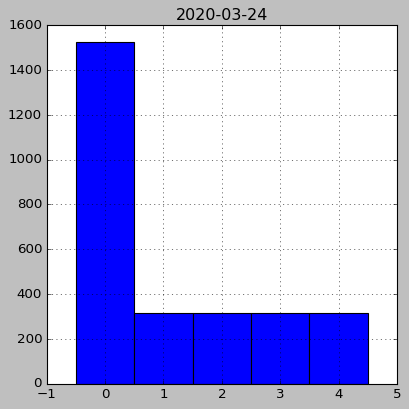

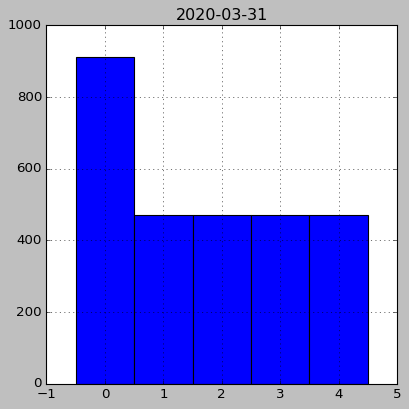

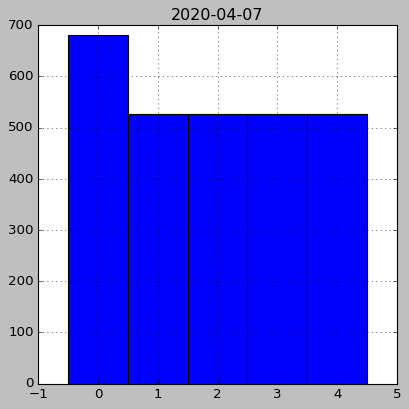

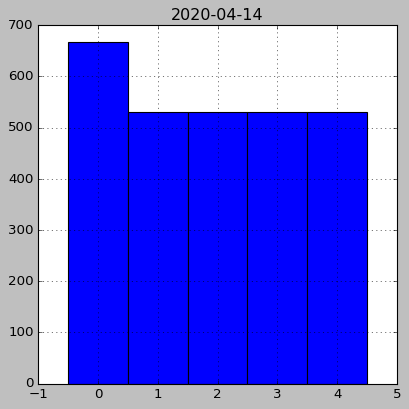

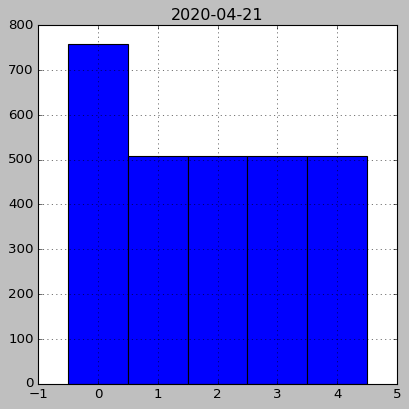

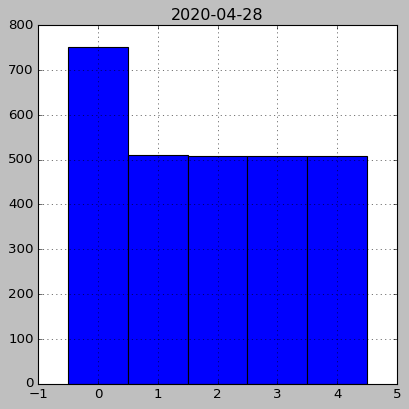

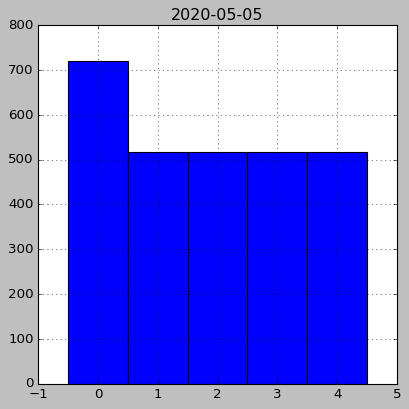

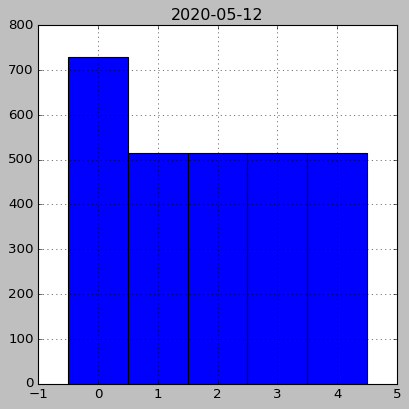

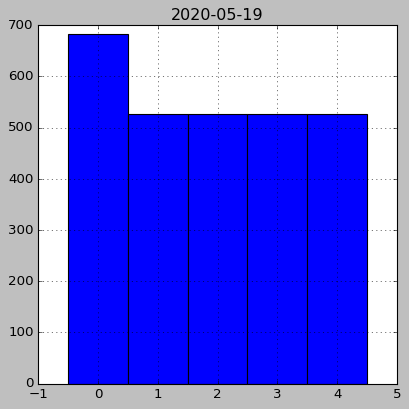

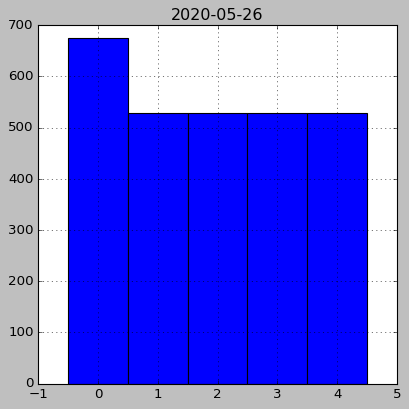

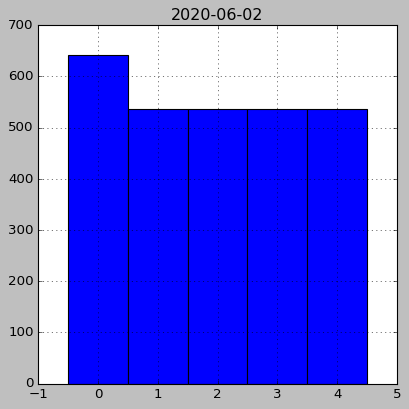

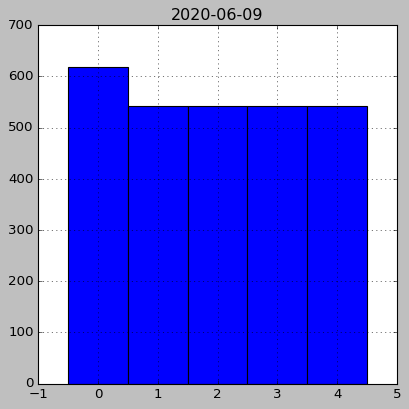

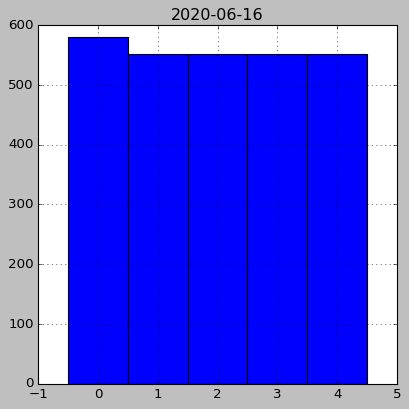

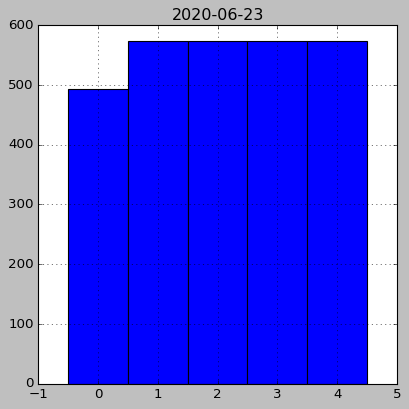

In [333]:
for each in week_adjust_2:
    df_temp = featuresByCounties_2[each]['CDC_New_per_100K'][featuresByCounties_2[each]['CDC_New_per_100K']>0]
    q1,q2,q3,q4 = df_temp.quantile([0.25, 0.5, 0.75, 1])
    plt.style.use('classic')
    fig_bump = plt.figure(constrained_layout=True, figsize=(5,5))
    featuresByCounties_2[each]['CDC_New_per_100K'].apply(lambda x:Separate_new(x, q1, q2, q3, q4)).hist(bins=[0,1,2,3,4,5], align='left')
    plt.title(each)
    foo_fig = plt.gcf()  # 'get current figure'
    foo_fig.savefig('hist_'+each+'_.png')
    #plt.tight_layout()
    plt.show()

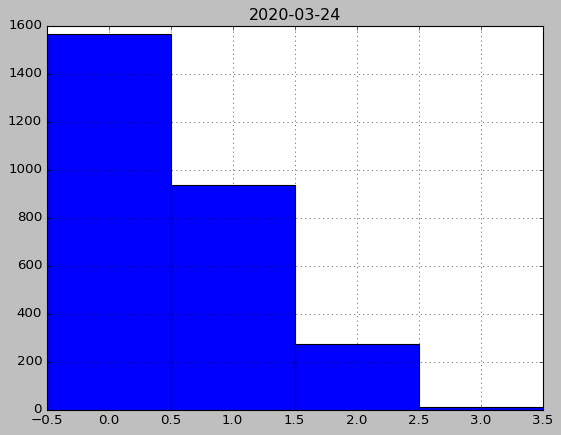

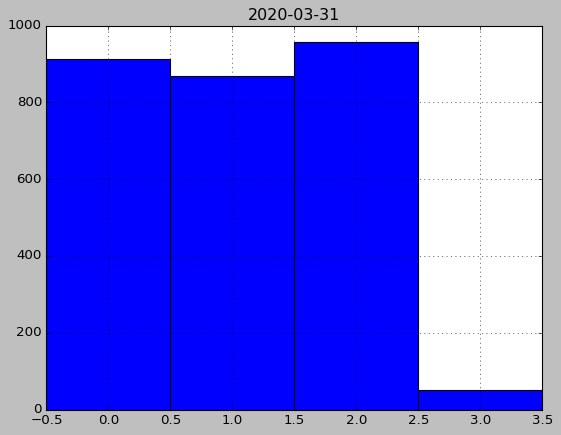

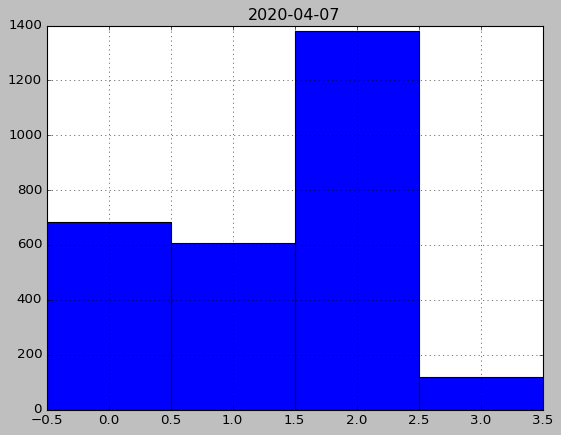

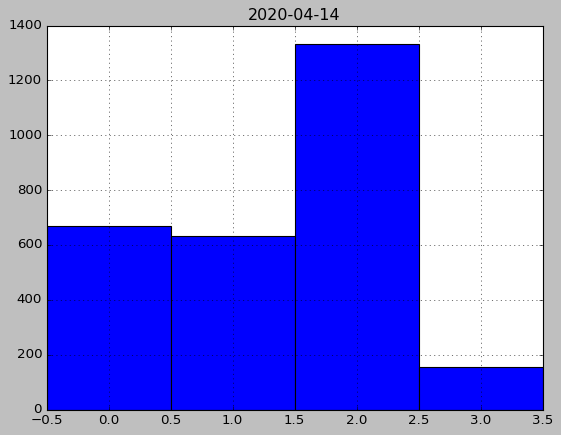

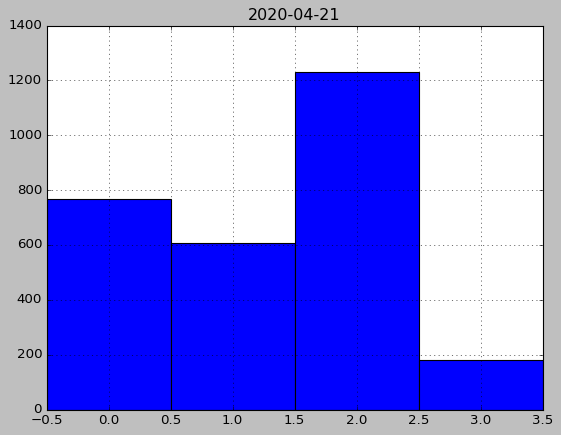

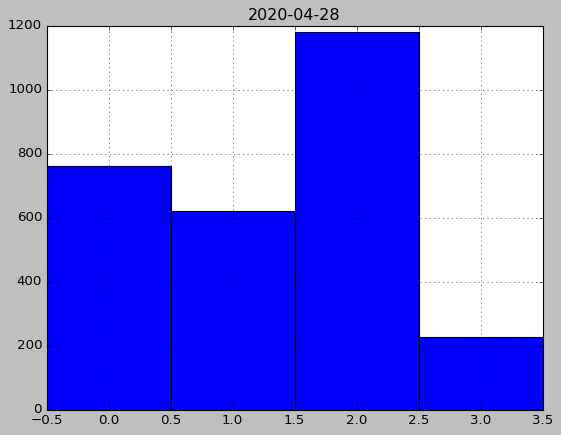

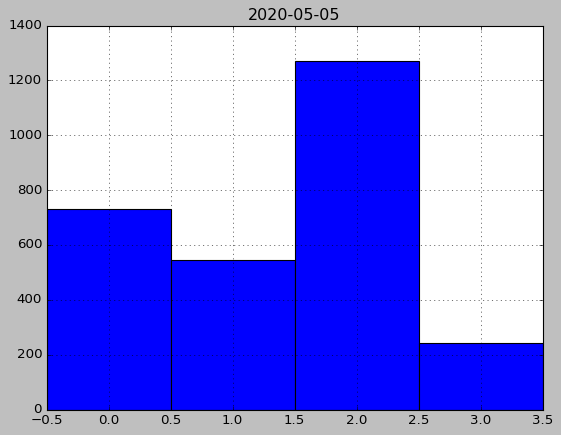

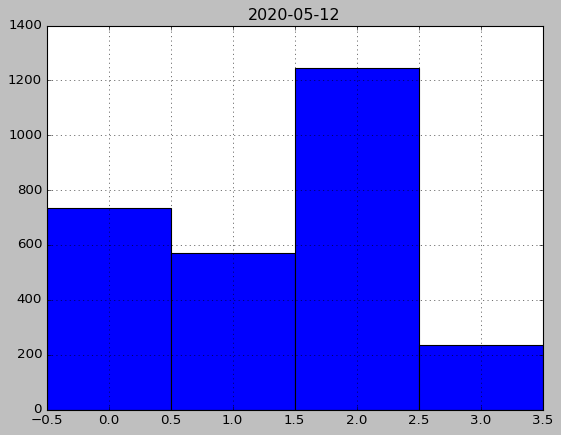

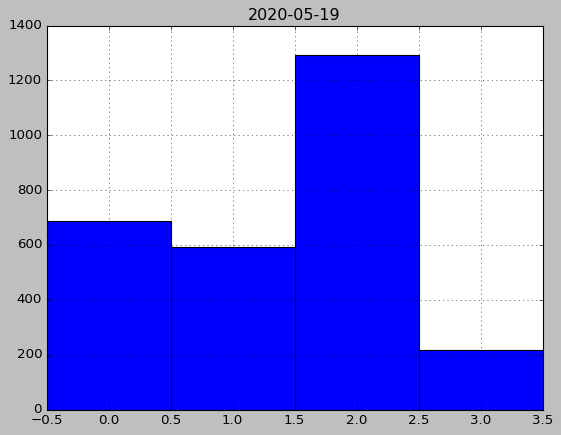

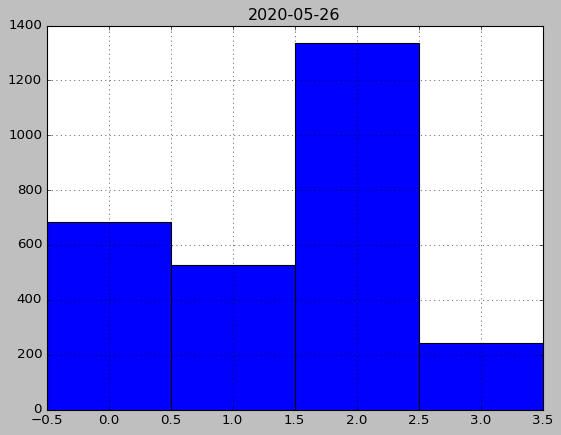

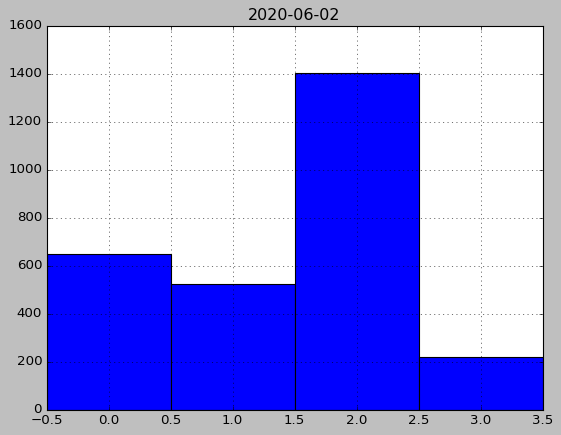

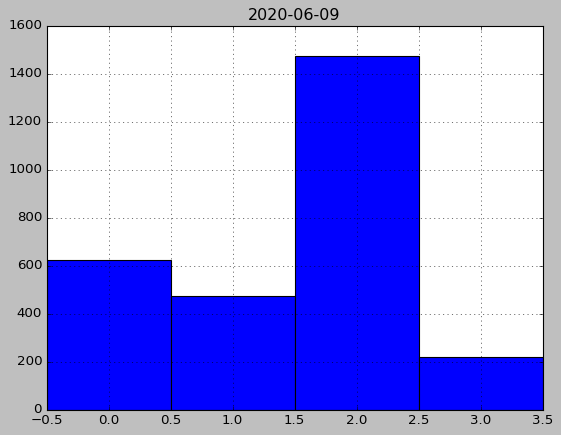

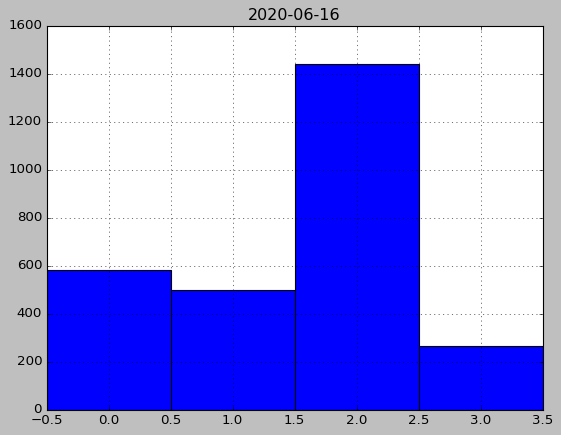

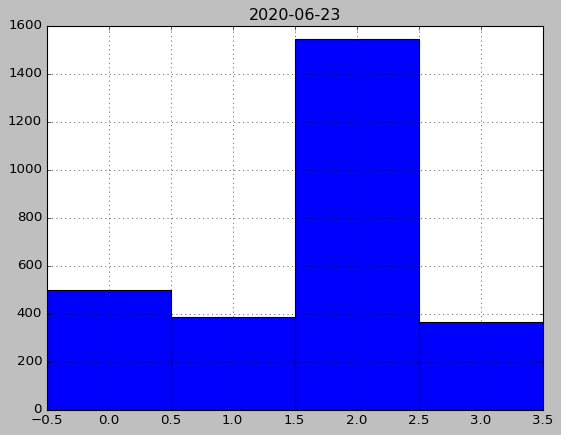

In [926]:
for each in week_adjust_2:
    featuresByCounties_2[each]['CDC_New_per_100K'].apply(lambda x:Separate(x)).hist(bins=[0,1,2,3,4], align='left')
    plt.title(each)
    plt.show()

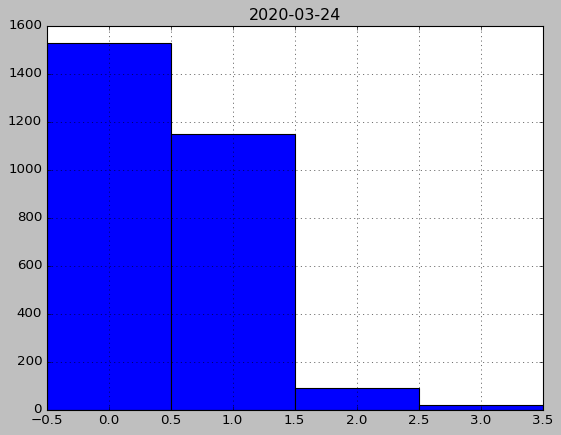

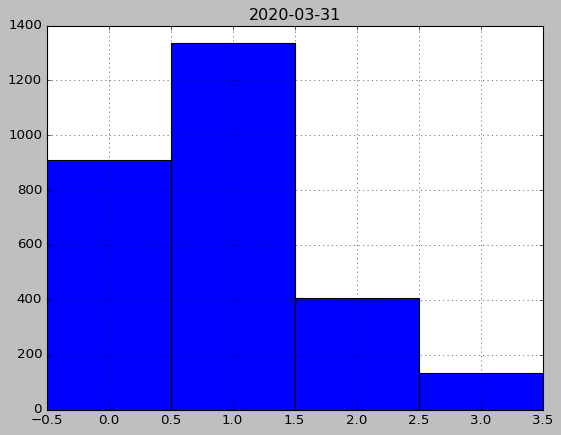

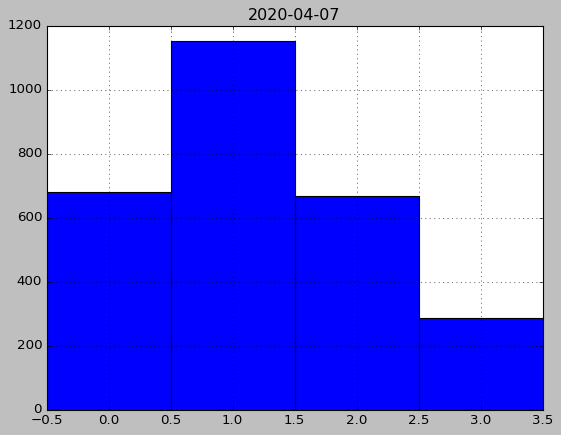

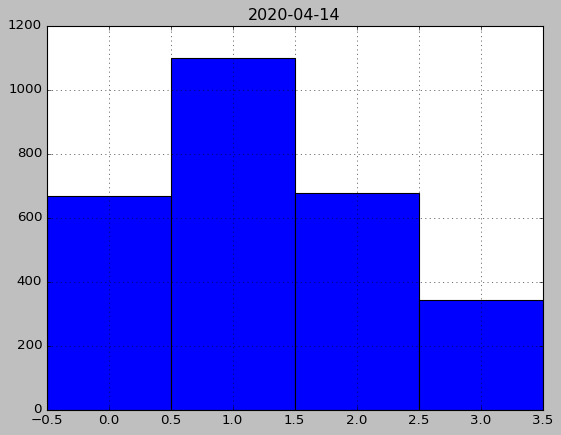

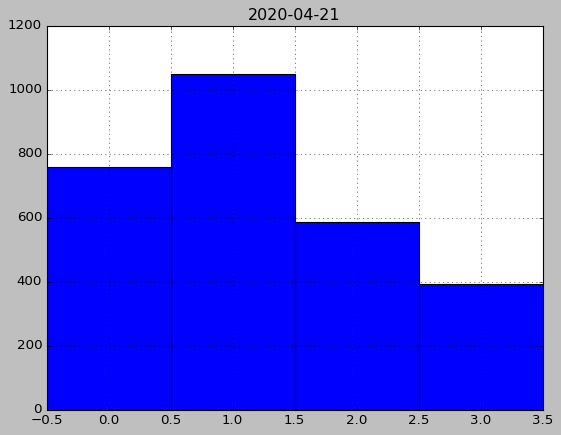

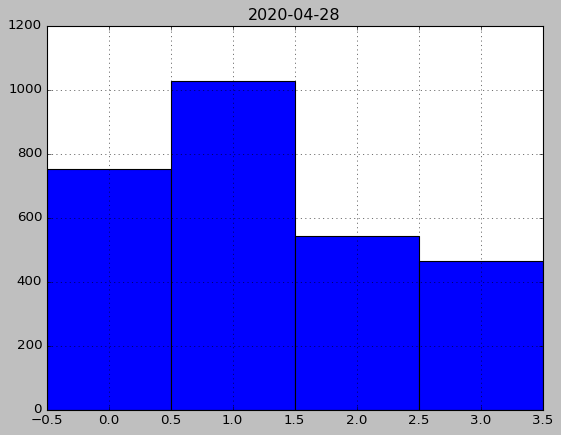

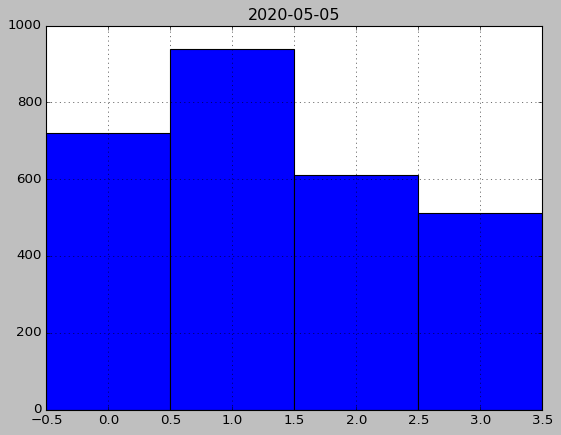

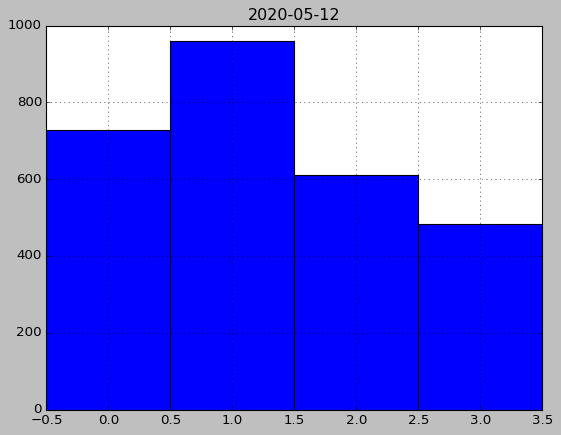

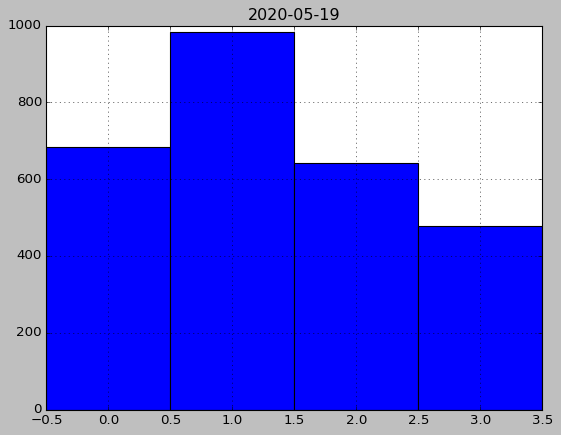

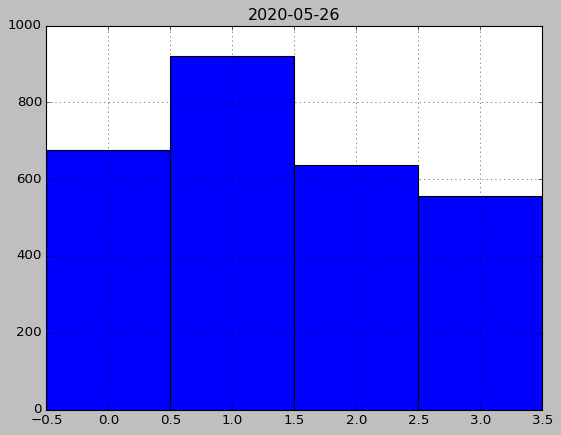

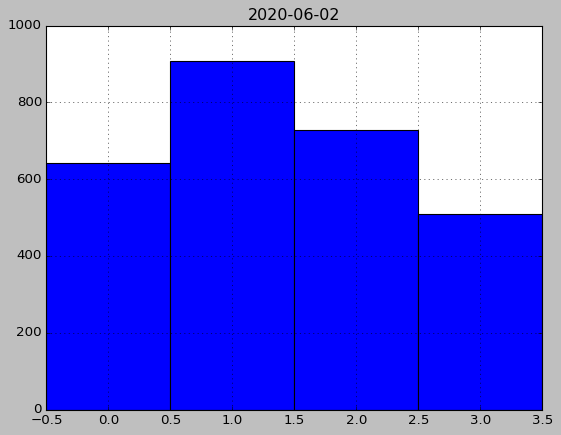

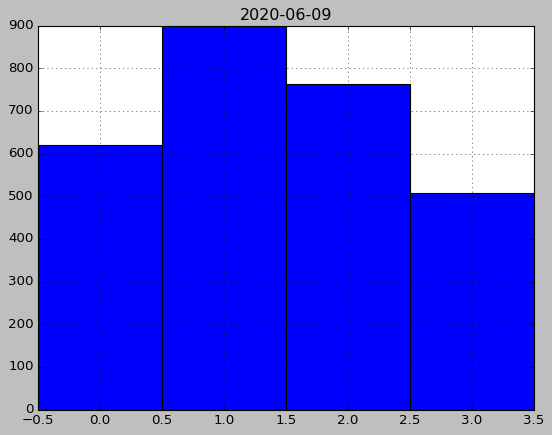

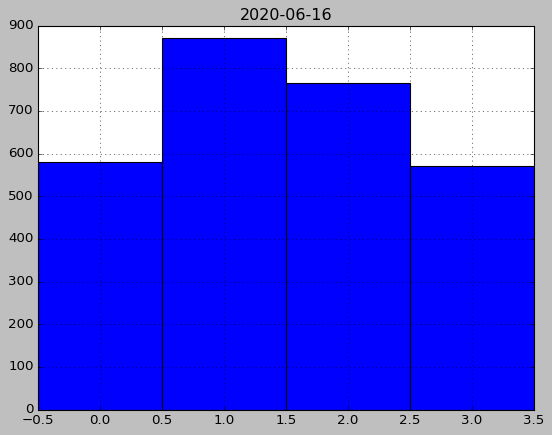

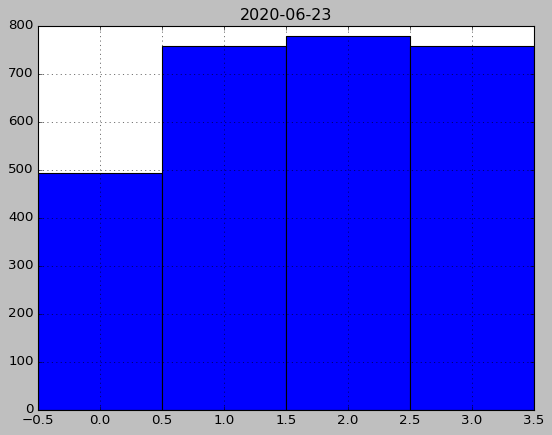

In [1042]:
for each in week_adjust_2:
    featuresByCounties_2[each]['CDC_New_per_100K'].apply(lambda x:Separate3(x,q1, q2, q3)).hist(bins=[0,1,2,3,4], align='left')
    plt.title(each)
    plt.show()

# Read results of model 2, 3, 4, 5 (different population densities)

In [466]:
import json

feature_to_rank,feature_to_predict=('Pop_den','Catg_CDC_New_per_100K_log')

with open('feature_importance_results_{}_{}_3.json'.format(feature_to_rank,feature_to_predict),'r') as f:
    feature_importance_results=json.load(f)
    
with open('test_stat_{}_{}_3.json'.format(feature_to_rank,feature_to_predict),'r') as f:
    test_stats=json.load(f)
    
with open('train_stat_{}_{}_3.json'.format(feature_to_rank,feature_to_predict),'r') as f:
    train_stats=json.load(f)

# Read results of model 1

In [357]:
import json


feature_to_rank,feature_to_predict=('CDC_New_per_100K','Catg_CDC_New_per_100K_log')

with open('feature_importance_results_{}_{}_3.json'.format(feature_to_rank,feature_to_predict),'r') as f:
    feature_importance_results_case=json.load(f)
    
with open('test_stat_{}_{}_3.json'.format(feature_to_rank,feature_to_predict),'r') as f:
    test_stats_case=json.load(f)
    
with open('train_stat_{}_{}_3.json'.format(feature_to_rank,feature_to_predict),'r') as f:
    train_stats_case=json.load(f)

# Accuracy figure

In [92]:
fig_dict = {i:{} for i in week_adjust_2}
fig_dict_case = {i:{} for i in week_adjust_2}

In [93]:
for k,v in test_stats.items():
    fig_dict[k]['base'] = v['base']['accuracy']
    fig_dict[k]['top_10'] = v['top_10']['accuracy']
    fig_dict[k]['top_10_20'] = v['top_10_20']['accuracy']
    fig_dict[k]['top_20_30'] = v['top_20_30']['accuracy']
    
for k,v in test_stats_case.items():
    fig_dict_case[k]['base'] = v['base']['accuracy']
    

In [94]:
accu_df = pd.DataFrame(fig_dict).T

In [96]:
accu_df['base1']=pd.DataFrame(fig_dict_case).T['base']

In [97]:
accu_df

,base,top_10,top_10_20,top_20_30,base1
2020-03-24,0.627913,0.398016,0.380556,0.337302,0.624322
2020-03-31,0.453537,0.494312,0.290741,0.327513,0.462848
2020-04-07,0.425569,0.483333,0.333598,0.345370,0.432031
2020-04-14,0.422350,0.501587,0.365873,0.276720,0.432749
2020-04-21,0.448508,0.497619,0.376058,0.266799,0.451730
2020-04-28,0.451026,0.501720,0.276058,0.248413,0.446705
2020-05-05,0.424108,0.447487,0.279894,0.341931,0.433074
2020-05-12,0.442052,0.497884,0.294180,0.280688,0.453544
2020-05-19,0.431998,0.473016,0.283862,0.331481,0.442755
2020-05-26,0.424121,0.404233,0.315608,0.251455,0.427339


In [49]:
month_day = []
for each in week_adjust_2:
    month_day.append(each[5:])

/Users/liqingchun/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Users/liqingchun/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


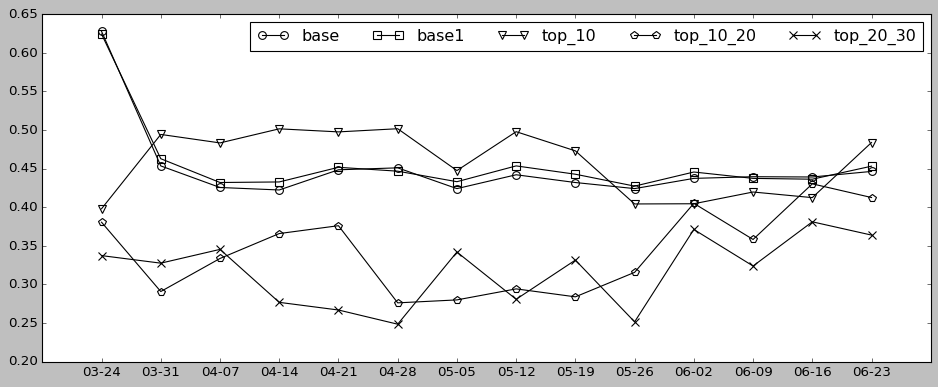

In [98]:
fig = plt.figure(figsize=(12,5))
plt.style.use('classic')
plt.plot(np.arange(1, len(accu_df.index)+1),accu_df['base'],label='base', marker='o', markerfacecolor='none', color='black',
        markersize=7, mew=1)
plt.plot(np.arange(1, len(accu_df.index)+1),accu_df['base1'],label='base1', marker='s', markerfacecolor='none', color='black',
        markersize=7, mew=1)
plt.plot(np.arange(1, len(accu_df.index)+1),accu_df['top_10'],label='top_10', marker='v', markerfacecolor='none', color='black',
        markersize=7, mew=1)
plt.plot(np.arange(1, len(accu_df.index)+1),accu_df['top_10_20'],label='top_10_20', marker='p', markerfacecolor='none', color='black',
        markersize=7, mew=1)
plt.plot(np.arange(1, len(accu_df.index)+1),accu_df['top_20_30'],label='top_20_30', marker='x', markerfacecolor='none', color='black',
        markersize=7, mew=1)
plt.tight_layout()
plt.legend(ncol=5)
plt.xlim(right=15)
xticks = ['']+month_day+['']
plt.xticks(np.arange(16), xticks)
foo_fig = plt.gcf()  # 'get current figure'
foo_fig.savefig('test_accuracy.png')
plt.show()

# Feature importance of model 2, 3, 4, 5 (different population densities)

In [52]:
feature_by_percentile_by_week={}

max_feature_by_percentile_by_week={k:{} for k in ['base','top_20_30','top_10_20','top_10']}

for week in week_adjust_2:
#for week in week_adjust[4:-1]:
    print(week)
    feature_importance_result=feature_importance_results[week]
    featuredf=pd.DataFrame(feature_importance_result)
    for i,row in featuredf.iterrows():
        for k in ['base','top_20_30','top_10_20','top_10']:
            if i not in feature_by_percentile_by_week: feature_by_percentile_by_week[i]={}
            if k not in feature_by_percentile_by_week[i]: feature_by_percentile_by_week[i][k]={}
            feature_by_percentile_by_week[i][k][week]=row[k]
    for k in ['base','top_20_30','top_10_20','top_10']:
        #max_feature_by_percentile_by_week[k][week]=featuredf[k].nlargest(3).index
        max_feature_by_percentile_by_week[k][week]=featuredf[k].nlargest(23).index
feature_by_percentile_by_week

2020-03-24
2020-03-31
2020-04-07
2020-04-14
2020-04-21
2020-04-28
2020-05-05
2020-05-12
2020-05-19
2020-05-26
2020-06-02
2020-06-09
2020-06-16
2020-06-23


{'Colo_dgre_Cent': {'base': {'2020-03-24': 0.037213540140983534,
   '2020-03-31': 0.045032242015215024,
   '2020-04-07': 0.039572119888503274,
   '2020-04-14': 0.042814984234847184,
   '2020-04-21': 0.03694479259552142,
   '2020-04-28': 0.0384075785960315,
   '2020-05-05': 0.03821007286904961,
   '2020-05-12': 0.04135916978947595,
   '2020-05-19': 0.042523344560924624,
   '2020-05-26': 0.04117189417342755,
   '2020-06-02': 0.04051567290227869,
   '2020-06-09': 0.03700743293495242,
   '2020-06-16': 0.037490683081690186,
   '2020-06-23': 0.03693918919145919},
  'top_20_30': {'2020-03-24': 0.04211598990366683,
   '2020-03-31': 0.04453683898209867,
   '2020-04-07': 0.037042863978544636,
   '2020-04-14': 0.056224162832610856,
   '2020-04-21': 0.04522876610574737,
   '2020-04-28': 0.04005308129207604,
   '2020-05-05': 0.03950082291308764,
   '2020-05-12': 0.041868898751002234,
   '2020-05-19': 0.050443191137789146,
   '2020-05-26': 0.04565828558321579,
   '2020-06-02': 0.03342800890542805,
 

# feature importance of mode 1

In [106]:
feature_by_percentile_by_week={}

max_feature_by_percentile_by_week={k:{} for k in ['base']}

for week in week_adjust_2:
#for week in week_adjust[4:-1]:
    print(week)
    feature_importance_result=feature_importance_results_case[week]
    featuredf=pd.DataFrame(feature_importance_result)
    for i,row in featuredf.iterrows():
        for k in ['base']:
            if i not in feature_by_percentile_by_week: feature_by_percentile_by_week[i]={}
            if k not in feature_by_percentile_by_week[i]: feature_by_percentile_by_week[i][k]={}
            feature_by_percentile_by_week[i][k][week]=row[k]
    for k in ['base']:
        #max_feature_by_percentile_by_week[k][week]=featuredf[k].nlargest(3).index
        max_feature_by_percentile_by_week[k][week]=featuredf[k].nlargest(23).index
feature_by_percentile_by_week

2020-03-24
2020-03-31
2020-04-07
2020-04-14
2020-04-21
2020-04-28
2020-05-05
2020-05-12
2020-05-19
2020-05-26
2020-06-02
2020-06-09
2020-06-16
2020-06-23


{'AM_total_home': {'base': {'2020-03-24': 0.033038126605664506,
   '2020-03-31': 0.03584659416425593,
   '2020-04-07': 0.03418346667786511,
   '2020-04-14': 0.03484585365576102,
   '2020-04-21': 0.03523779383406482,
   '2020-04-28': 0.03505065583792381,
   '2020-05-05': 0.03535075186048264,
   '2020-05-12': 0.035254302692670186,
   '2020-05-19': 0.035922289252313534,
   '2020-05-26': 0.03618918375321033,
   '2020-06-02': 0.03654092937444865,
   '2020-06-09': 0.03445261610110372,
   '2020-06-16': 0.03428524317908803,
   '2020-06-23': 0.034117592706611286}},
 'AM_total_outdoor': {'base': {'2020-03-24': 0.03356702977557038,
   '2020-03-31': 0.037154776016606925,
   '2020-04-07': 0.03594989940602343,
   '2020-04-14': 0.03502996292011627,
   '2020-04-21': 0.03489838058458555,
   '2020-04-28': 0.03236712456450716,
   '2020-05-05': 0.034314765995729204,
   '2020-05-12': 0.03473938745991357,
   '2020-05-19': 0.03571832541230827,
   '2020-05-26': 0.03464367432124154,
   '2020-06-02': 0.03395527

In [107]:
max_feature_by_percentile_by_week.keys()

dict_keys(['base'])

# Generate rank of features in each week

In [103]:
features = ['GDP_2018', 'CCVI_Socioeconomic_Status', 'CCVI_Household_Composisition_Disability',
           'CCVI_Minority_Status_Language', 'CCVI_Housing_Type_Transportation', 'CCVI_Epdiemiological_Factors',
           'CCVI_Healthcare_System_Factors', 'CCVI_overall', 'POI_Visit', 'SIP', 'AM_total_social',
           'AM_total_work', 'AM_total_outdoor', 'AM_total_home', 'DI', 'Cuebiq_cmi', 'Cuebiq_sip',
           'Cens_in_dgre','Cens_out_dgre', 'Colo_dgre_Cent', 'R0', 'SCI_County', 'Pop_den'] # 'Pop_den',

In [108]:
base_case = pd.DataFrame.from_dict(max_feature_by_percentile_by_week['base'])

#features = ['Colo_dgre_Cent','DI','POI_Visit',
           #'SIP','R0','Cens_in_dgre','Cens_out_dgre','AM_total_home',
           #'AM_total_outdoor','AM_total_social','AM_total_work','Cuebiq_cmi','Cuebiq_sip',
           #'CCVI_Socioeconomic_Status','CCVI_Household_Composisition_Disability',
           #'CCVI_Minority_Status_Language','CCVI_Housing_Type_Transportation',
            #'CCVI_Epdiemiological_Factors','CCVI_Healthcare_System_Factors',
           #'CCVI_overall','SCI_County', 'GDP_2018','Pop_den']
base_case = base_case.set_index(np.array(features))

base_case_rank = base_case.copy()
week_model = ['2020-03-24','2020-03-31','2020-04-07','2020-04-14',
                '2020-04-21','2020-04-28','2020-05-05','2020-05-12',
              '2020-05-19','2020-05-26','2020-06-02','2020-06-09','2020-06-16','2020-06-23']
for week in week_model:
    for each_feature in features:
        base_case_rank[week][each_feature] = list(base_case[week]).index(each_feature)+1

In [109]:
features_rename = ['GDP', 'Socioeconomic status', 'Household composition',
                  'Minority status', 'Housing type', 'Epidemiologic factors',
                  'Healthcare system', 'Overall CCVI', 'POI visits',
                  'SDI', 'UAI(social)', 'UAI(work)',
                  'UAI(traffic)', 'UAI(home)', 'Venables Distance',
                  'Cuebiq CMI', 'Cuebiq SIP', 'County in-DC',
                  'County out-DC', 'Colocation DC', 'R0', 'SCI', 'Population density'] #'Population density', 

In [110]:
base_case_rank = base_case_rank.set_index(np.array(features_rename))

In [111]:
base_case_rank_new = base_case_rank.T.set_index(np.arange(1,15))

In [112]:
base_case_rank_new.T

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
GDP,1,1,3,3,4,4,3,4,4,5,4,4,4,4
Socioeconomic status,14,11,12,8,11,9,10,13,10,6,6,6,6,6
Household composition,8,15,23,22,23,23,22,18,19,22,23,22,23,17
Minority status,10,8,4,5,5,5,4,3,3,3,2,1,1,1
Housing type,13,14,13,15,9,10,9,7,15,10,10,10,12,13
Epidemiologic factors,11,10,9,9,12,14,13,17,14,15,18,19,17,22
Healthcare system,22,21,14,12,10,13,18,16,11,12,16,14,14,18
Overall CCVI,21,19,15,14,15,12,14,11,16,17,9,7,7,7
POI visits,4,6,7,16,13,8,12,15,9,13,11,11,11,10
SDI,9,4,11,13,8,11,11,8,13,8,13,12,16,11


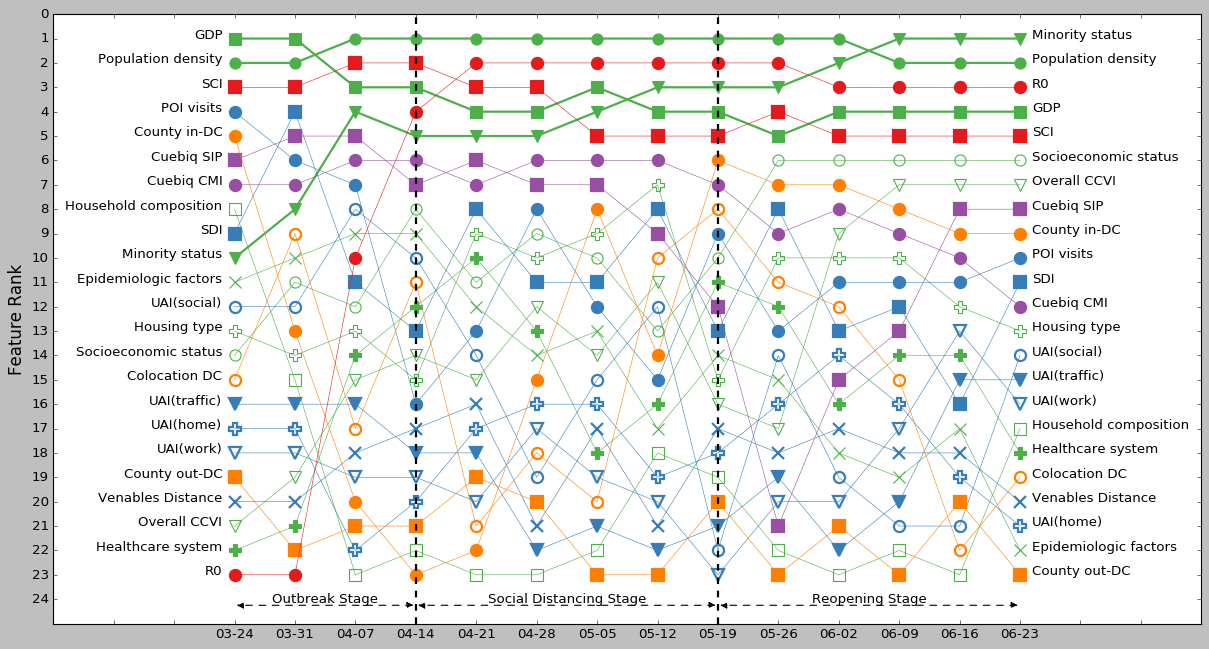

In [114]:
import matplotlib.gridspec as gridspec
plt.style.use('classic')
fig_bump = plt.figure(constrained_layout=True, figsize=(15,8))
#fig_bump = plt.figure(constrained_layout=True, figsize=(15,23))


gs = fig_bump.add_gridspec(23, 3)
#f3_ax24 = fig_bump.add_subplot(gs[:,1:])
f3_ax24 = fig_bump.add_subplot(gs[:,:])
f3_ax24.set_ylabel('Feature Rank', fontsize=15)
f3_ax24.set_xticks(np.arange(-2,18))
x_tick = ['','','']+['03-24','03-31','04-07','04-14','04-21','04-28','05-05','05-12','05-19','05-26','06-02',
                    '06-09','06-16','06-23']+['','','']
f3_ax24.set_xticklabels(x_tick )
f3_ax24.set_yticks(np.arange(0,25))

##Social demographic features

pc_kwargs_1 = {'color': '#4daf4a', 'legend':False, 'xlim':(-2,17), 'ylim':(0,25), 'ls':'-', 'markersize':10, 
              'linewidth':0.5, 'mew':1, 'markeredgecolor':'#4daf4a'}

pc_kwargs_1a = {'color': '#4daf4a', 'legend':False, 'xlim':(-2,17), 'ylim':(0,25), 'ls':'-', 'markersize':10, 
              'linewidth':2, 'mew':1, 'markeredgecolor':'#4daf4a'}

if min(base_case_rank_new['Population density'])<=1:
    base_case_rank_new['Population density'].plot(ax=f3_ax24, marker='o', **pc_kwargs_1a)
else:
    base_case_rank_new['Population density'].plot(ax=f3_ax24, marker='o', **pc_kwargs_1)

if min(base_case_rank_new['GDP'])<=1:
    base_case_rank_new['GDP'].plot(ax=f3_ax24, marker='s', **pc_kwargs_1a)
else:
    base_case_rank_new['GDP'].plot(ax=f3_ax24, marker='s', **pc_kwargs_1)

if min(base_case_rank_new['Socioeconomic status'])<=1:
    base_case_rank_new['Socioeconomic status'].plot(ax=f3_ax24, marker='o', markerfacecolor='none', **pc_kwargs_1a)
else:
    base_case_rank_new['Socioeconomic status'].plot(ax=f3_ax24, marker='o', markerfacecolor='none', **pc_kwargs_1)
    
if min(base_case_rank_new['Household composition'])<=1:
    base_case_rank_new['Household composition'].plot(ax=f3_ax24, marker='s', markerfacecolor='none', **pc_kwargs_1a)
else:
    base_case_rank_new['Household composition'].plot(ax=f3_ax24, marker='s', markerfacecolor='none', **pc_kwargs_1)
    
if min(base_case_rank_new['Minority status'])<=1:
    base_case_rank_new['Minority status'].plot(ax=f3_ax24, marker='v', **pc_kwargs_1a)
else:
    base_case_rank_new['Minority status'].plot(ax=f3_ax24, marker='v', **pc_kwargs_1)
    
if min(base_case_rank_new['Housing type'])<=1:    
    base_case_rank_new['Housing type'].plot(ax=f3_ax24, marker='P', markerfacecolor='none', 
                                            **pc_kwargs_1a)
else:
    base_case_rank_new['Housing type'].plot(ax=f3_ax24, marker='P', markerfacecolor='none', 
                                            **pc_kwargs_1)
    
if min(base_case_rank_new['Epidemiologic factors'])<=1:    
    base_case_rank_new['Epidemiologic factors'].plot(ax=f3_ax24, marker='x', **pc_kwargs_1a)
else:
    base_case_rank_new['Epidemiologic factors'].plot(ax=f3_ax24, marker='x', **pc_kwargs_1)

if min(base_case_rank_new['Healthcare system'])<=1:    
    base_case_rank_new['Healthcare system'].plot(ax=f3_ax24, marker='P', **pc_kwargs_1a)
else:
    base_case_rank_new['Healthcare system'].plot(ax=f3_ax24, marker='P', **pc_kwargs_1)
    
if min(base_case_rank_new['Overall CCVI'])<=1:
    base_case_rank_new['Overall CCVI'].plot(ax=f3_ax24, marker='v', markerfacecolor='none', **pc_kwargs_1a)
else:
    base_case_rank_new['Overall CCVI'].plot(ax=f3_ax24, marker='v', markerfacecolor='none', **pc_kwargs_1)

##population activity features

pc_kwargs_2 = {'color': '#377eb8', 'legend':False, 'xlim':(-2,17), 'ylim':(0,25), 'ls':'-', 'markersize':10, 
              'linewidth':0.5, 'mew':2, 'markeredgecolor':'#377eb8'}

pc_kwargs_2a = {'color': '#377eb8', 'legend':False, 'xlim':(-2,17), 'ylim':(0,25), 'ls':'-', 'markersize':10, 
              'linewidth':2, 'mew':2, 'markeredgecolor':'#377eb8'}

if min(base_case_rank_new['POI visits'])<=1:
    base_case_rank_new['POI visits'].plot(ax=f3_ax24, marker='o', **pc_kwargs_2a)
else:
    base_case_rank_new['POI visits'].plot(ax=f3_ax24, marker='o', **pc_kwargs_2)
    
if min(base_case_rank_new['SDI'])<=1:
    base_case_rank_new['SDI'].plot(ax=f3_ax24, marker='s', **pc_kwargs_2a)
else:
    base_case_rank_new['SDI'].plot(ax=f3_ax24, marker='s', **pc_kwargs_2)
    
if min(base_case_rank_new['UAI(social)'])<=1:
    base_case_rank_new['UAI(social)'].plot(ax=f3_ax24, marker='o', markerfacecolor='none', 
                                           **pc_kwargs_2a)
else:
    base_case_rank_new['UAI(social)'].plot(ax=f3_ax24, marker='o', markerfacecolor='none', 
                                           **pc_kwargs_2)

if min(base_case_rank_new['UAI(work)'])<=1:
    base_case_rank_new['UAI(work)'].plot(ax=f3_ax24, marker='v', markerfacecolor='none', **pc_kwargs_2a)
else:
    base_case_rank_new['UAI(work)'].plot(ax=f3_ax24, marker='v', markerfacecolor='none', **pc_kwargs_2)

if min(base_case_rank_new['UAI(traffic)'])<=1:
    base_case_rank_new['UAI(traffic)'].plot(ax=f3_ax24, marker='v',**pc_kwargs_2a)
else:
    base_case_rank_new['UAI(traffic)'].plot(ax=f3_ax24, marker='v',**pc_kwargs_2)
    
if min(base_case_rank_new['UAI(home)'])<=1:   
    base_case_rank_new['UAI(home)'].plot(ax=f3_ax24, marker='P', markerfacecolor='none', **pc_kwargs_2a)
else:
    base_case_rank_new['UAI(home)'].plot(ax=f3_ax24, marker='P', markerfacecolor='none', **pc_kwargs_2)
    
if min(base_case_rank_new['Venables Distance'])<=1:
    base_case_rank_new['Venables Distance'].plot(ax=f3_ax24, marker='x', **pc_kwargs_2a)
else:
    base_case_rank_new['Venables Distance'].plot(ax=f3_ax24, marker='x', **pc_kwargs_2)

##Within-county mobility features

pc_kwargs_3 = {'color': '#984ea3', 'legend':False, 'xlim':(-2,17), 'ylim':(0,25), 'ls':'-', 'markersize':10, 
              'linewidth':0.5, 'mew':2, 'markeredgecolor':'#984ea3'}

pc_kwargs_3a = {'color': '#984ea3', 'legend':False, 'xlim':(-2,17), 'ylim':(0,25), 'ls':'-', 'markersize':10, 
              'linewidth':2, 'mew':2, 'markeredgecolor':'#984ea3'}

if min(base_case_rank_new['Cuebiq CMI'])<=1:
    base_case_rank_new['Cuebiq CMI'].plot(ax=f3_ax24, marker='o', **pc_kwargs_3a)
else:
    base_case_rank_new['Cuebiq CMI'].plot(ax=f3_ax24, marker='o', **pc_kwargs_3)
    
if min(base_case_rank_new['Cuebiq SIP'])<=1:
    base_case_rank_new['Cuebiq SIP'].plot(ax=f3_ax24, marker='s', **pc_kwargs_3a)
else:
    base_case_rank_new['Cuebiq SIP'].plot(ax=f3_ax24, marker='s', **pc_kwargs_3)

##across-county mobility features
pc_kwargs_4 = {'color': '#ff7f00', 'legend':False, 'xlim':(-2,16), 'ylim':(0,25), 'ls':'-', 'markersize':10, 
              'linewidth':0.5, 'mew':2, 'markeredgecolor':'#ff7f00'}

pc_kwargs_4a = {'color': '#ff7f00', 'legend':False, 'xlim':(-2,16), 'ylim':(0,25), 'ls':'-', 'markersize':10, 
              'linewidth':2, 'mew':2, 'markeredgecolor':'#ff7f00'}

if min(base_case_rank_new['County in-DC'])<=1:
    base_case_rank_new['County in-DC'].plot(ax=f3_ax24, marker='o', **pc_kwargs_4a)
else:
    base_case_rank_new['County in-DC'].plot(ax=f3_ax24, marker='o', **pc_kwargs_4)
    
if min(base_case_rank_new['County out-DC'])<=1:
    base_case_rank_new['County out-DC'].plot(ax=f3_ax24, marker='s', **pc_kwargs_4a)
else:
    base_case_rank_new['County out-DC'].plot(ax=f3_ax24, marker='s', **pc_kwargs_4)
    
if min(base_case_rank_new['Colocation DC'])<=1:
    base_case_rank_new['Colocation DC'].plot(ax=f3_ax24, marker='o', markerfacecolor='none', **pc_kwargs_4a)
else:
    base_case_rank_new['Colocation DC'].plot(ax=f3_ax24, marker='o', markerfacecolor='none', **pc_kwargs_4)
    
##disease attribute feature and social network structure feature
pc_kwargs_5 = {'color': '#e41a1c', 'legend':False, 'xlim':(-2,17), 'ylim':(0,25), 'ls':'-', 'markersize':10, 
              'linewidth':0.5, 'mew':2, 'markeredgecolor':'#e41a1c'}

pc_kwargs_5a = {'color': '#e41a1c', 'legend':False, 'xlim':(-2,17), 'ylim':(0,25), 'ls':'-', 'markersize':10, 
              'linewidth':2, 'mew':2, 'markeredgecolor':'#e41a1c'}

if min(base_case_rank_new['R0'])<=1:
    base_case_rank_new['R0'].plot(ax=f3_ax24, marker='o', **pc_kwargs_5a)
else:
    base_case_rank_new['R0'].plot(ax=f3_ax24, marker='o', **pc_kwargs_5)
    
if min(base_case_rank_new['SCI'])<=1:
    base_case_rank_new['SCI'].plot(ax=f3_ax24, marker='s', **pc_kwargs_5a)
else:
    base_case_rank_new['SCI'].plot(ax=f3_ax24, marker='s', **pc_kwargs_5)

##annotation first week and last week
for each in features_rename:
    f3_ax24.text(0.8, base_case_rank_new.T[1][each], each ,{'color': 'black', 'ha': 'right'})
    f3_ax24.text(14.2, base_case_rank_new.T[14][each], each ,{'color': 'black', 'ha': 'left'})



# add different period
f3_ax24.axvline(x = 4, color='black', ls='--', linewidth=2)
f3_ax24.axvline(x = 9, color='black', ls='--', linewidth=2)

##add arrow

f3_ax24.annotate("", xy=(1, 24.25), xytext=(4, 24.25),
    arrowprops=dict(arrowstyle="<|-|>", connectionstyle="arc3", ls='--', color='black'))
f3_ax24.text(2.5, 24.25, 'Outbreak Stage', {'color': 'black', 'ha': 'center', 'va': 'bottom'})

f3_ax24.annotate("", xy=(4, 24.25), xytext=(9, 24.25),
    arrowprops=dict(arrowstyle="<|-|>", connectionstyle="arc3", ls='--', color='black'))
f3_ax24.text(6.5, 24.25, 'Social Distancing Stage', {'color': 'black', 'ha': 'center', 'va': 'bottom'})

f3_ax24.annotate("", xy=(9, 24.25), xytext=(14, 24.25),
    arrowprops=dict(arrowstyle="<|-|>", connectionstyle="arc3", ls='--', color='black'))
f3_ax24.text(11.5, 24.25, 'Reopening Stage', {'color': 'black', 'ha': 'center', 'va': 'bottom'})


f3_ax24.invert_yaxis()  #reverse for rank

#for i in range(1,24):
    #locals()['f3_ax'+str(i)] = fig_bump.add_subplot(gs[i-1,0])
foo_fig = plt.gcf()  # 'get current figure'
foo_fig.savefig('base_with_pop_rank_classification.png')

# Save files

In [912]:
pd.DataFrame.from_dict(max_feature_by_percentile_by_week['base']).to_csv('base_rank_population.csv')

pd.DataFrame.from_dict(max_feature_by_percentile_by_week['top_10']).to_csv('top_10_rank_population.csv')

pd.DataFrame.from_dict(max_feature_by_percentile_by_week['top_10_20']).to_csv('top_10_20_rank_population.csv')

pd.DataFrame.from_dict(max_feature_by_percentile_by_week['top_20_30']).to_csv('top_20_30_rank_population.csv')

In [884]:
pd.DataFrame.from_dict(max_feature_by_percentile_by_week['base']).to_csv('base_rank_case.csv')

pd.DataFrame.from_dict(max_feature_by_percentile_by_week['top_10']).to_csv('top_10_rank_case.csv')

pd.DataFrame.from_dict(max_feature_by_percentile_by_week['top_10_20']).to_csv('top_10_20_rank_case.csv')

pd.DataFrame.from_dict(max_feature_by_percentile_by_week['top_20_30']).to_csv('top_20_30_rank_case.csv')